In [1]:
import clip
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# 设置随机种子以确保可重复性
torch.manual_seed(42)

# 基础设置
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), 
                       (0.26862954, 0.26130258, 0.27577711))
])

dataset = datasets.CIFAR100(root="../data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
class_names = dataset.classes

Files already downloaded and verified


In [2]:
# 加载CIFAR100数据集的超类信息
superclass_dict = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
    'household electrical devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

# 创建子类到超类的映射
subclass_to_superclass = {}
for superclass, subclasses in superclass_dict.items():
    for subclass in subclasses:
        subclass_to_superclass[subclass] = superclass

In [3]:
def evaluate_prompts(prompt_type, text_prompts):
    print(f"\n评估 {prompt_type} prompt:")
    
    # 记录开始时间
    start_time = time.time()
    
    # 编码文本
    text_tokens = clip.tokenize(text_prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Zero-shot分类评估
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="分类中"):
        images = images.to(device)
        
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = image_features @ text_features.T
            predictions = similarity.argmax(dim=1)
        
        correct += (predictions.cpu() == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total * 100
    elapsed_time = time.time() - start_time
    
    return accuracy, elapsed_time

In [4]:
# 生成两种prompt
simple_prompts = [f"a photo of a {classname}" for classname in class_names]
superclass_prompts = [f"a photo of a {classname}, which is a type of {subclass_to_superclass[classname]}" 
                     for classname in class_names]

# 评估两种prompt
simple_accuracy, simple_time = evaluate_prompts("Simple", simple_prompts)
super_accuracy, super_time = evaluate_prompts("Superclass", superclass_prompts)


评估 Simple prompt:


分类中: 100%|██████████| 1563/1563 [15:22<00:00,  1.70it/s]



评估 Superclass prompt:


分类中: 100%|██████████| 1563/1563 [10:29<00:00,  2.48it/s]



=== 实验结果对比 ===
简单Prompt准确率: 60.85% (用时: 929.73秒)
超类Prompt准确率: 60.89% (用时: 629.31秒)
准确率提升: 0.04%


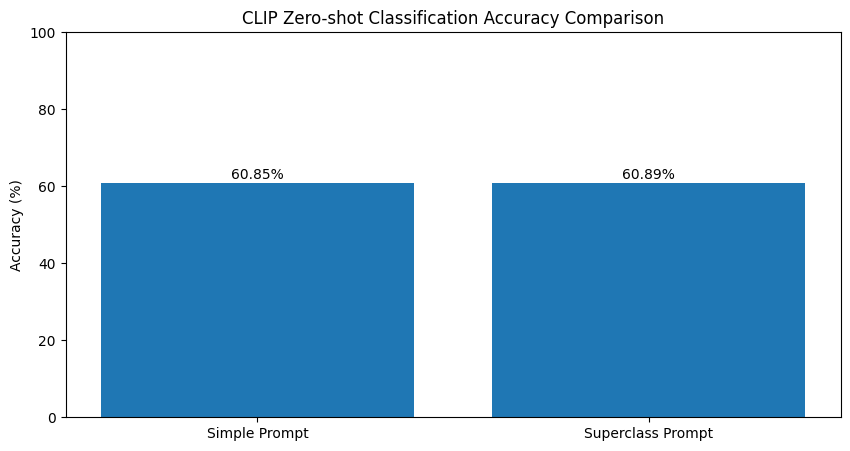

In [5]:
# 打印结果
print("\n=== 实验结果对比 ===")
print(f"简单Prompt准确率: {simple_accuracy:.2f}% (用时: {simple_time:.2f}秒)")
print(f"超类Prompt准确率: {super_accuracy:.2f}% (用时: {super_time:.2f}秒)")
print(f"准确率提升: {super_accuracy - simple_accuracy:.2f}%")

# 可视化结果
plt.figure(figsize=(10, 5))
plt.bar(['Simple Prompt', 'Superclass Prompt'], [simple_accuracy, super_accuracy])
plt.title('CLIP Zero-shot Classification Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# 在柱状图上添加具体数值
for i, v in enumerate([simple_accuracy, super_accuracy]):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')

plt.show()